In [121]:
import numpy as np
import pandas as pd
import random
from nltk.corpus import brown
import string
import matplotlib.pyplot as plt

In [165]:
brown_sents = brown.sents()

## Use this for shorter runtime
# brown_sents = brown.sents(categories='news')

### Data processing

In [166]:
# Pre-processing
brown_sents = np.array(brown_sents)
for i, sent in enumerate(brown_sents):
    new_sent = [''.join(char for char in word if char not in string.punctuation) for word in sent]
    brown_sents[i] = [word.lower() for word in new_sent if word]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [167]:
# Split corpus into 20 subcorpora by dividing sentences randomly
random.shuffle(brown_sents)
split = np.array_split(brown_sents, 20)

In [168]:
# Divide subcorpora in ranks and frequency corpora
ranks = split[:10]
freqs = split[10:]

In [169]:
# Join rank sentences together
for i, j in enumerate(ranks):
    ranks[i] = [item for sublist in j for item in sublist]

# Join frequency sentences together
for i, j in enumerate(freqs):
    freqs[i] = [item for sublist in j for item in sublist]

### Calculating the ranks

In [170]:
# For each rank subcorpus, create frequency dictionary from which ranks will be estimated
freqs_dicts_1 = {}
for i, j in enumerate(ranks):
    dict_i = {}
    for word in j:
        if word not in dict_i:
            dict_i[word] = 1
        else:
            dict_i[word] += 1
    freqs_dicts_1[i] = dict_i

In [171]:
# For each rank subcorpus, calculate ranks and put in dictionary
ranks_dicts = {}
for i in freqs_dicts_1:
    i_dict = freqs_dicts_1[i]
    ranked = {key: rank for rank, key in enumerate(sorted(i_dict, key=i_dict.get, reverse=True), 1)}
    ranks_dicts[i] = ranked

In [172]:
# Calculate average ranks
ranks_df = pd.DataFrame(ranks_dicts)
mean_ranks = ranks_df.mean(axis=1)

### Calculating the frequencies

In [173]:
# For each frequency subcorpus, create frequency dictionary
freqs_dicts_2 = {}
for i, j in enumerate(freqs):
    dict_i = {}
    for word in j:
        if word not in dict_i:
            dict_i[word] = 1
        else:
            dict_i[word] += 1
    freqs_dicts_2[i] = dict_i

In [174]:
# Calculate average frequencies
freqs_df = pd.DataFrame(freqs_dicts_2)
mean_freqs = freqs_df.mean(axis=1)

### Estimating Zipf's law

In [175]:
zipf = max(mean_freqs) * 1/mean_ranks
zipf_df = pd.concat([np.log(mean_ranks), np.log(zipf)], axis=1, sort=False)
zipf_df.set_axis(["Rank (log)", "Predicted frequency (log)"], axis=1, inplace=True)

### Results

In [197]:
df = pd.concat([mean_ranks, mean_freqs, round(zipf)], axis=1, sort=False)
df.set_axis(["Rank", "Frequency", "Estimated frequency"], axis=1, inplace=True)
df.style.set_caption("Hello World")
df.head(10)

,Rank,Frequency,Estimated frequency
the,1.0,3495.7,3496.0
of,2.0,1817.0,1748.0
and,3.0,1440.4,1165.0
to,4.0,1306.1,874.0
a,5.0,1164.2,699.0
in,6.0,1069.5,583.0
is,8.3,497.0,421.0
that,7.8,539.1,448.0
for,9.7,467.5,360.0
he,10.1,478.7,346.0


In [183]:
# Take logs
df_log = pd.concat([np.log(mean_ranks), np.log(mean_freqs)], axis=1, sort=False)
df_log.set_axis(["Rank (log)", "Frequency (log)"], axis=1, inplace=True)

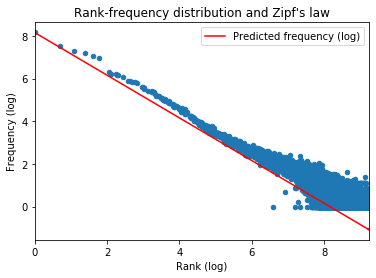

In [190]:
ax = df_log.plot(x ='Rank (log)', y='Frequency (log)', kind = 'scatter')
zipf_df.plot(x ='Rank (log)', y='Predicted frequency (log)', kind = 'line', ax=ax, color='red')
plt.title("Rank-frequency distribution and Zipf's law")
plt.show()